# Students Performance in 2024 JAMB
## Data Preparation

1. Load the dataset using the provided link.
2. Prepare the dataset by making the column names lowercase and removing spaces.

In [1]:
import pandas as pd

# Download the dataset
!wget -q https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv

# Load the dataset
df = pd.read_csv("jamb_exam_results.csv")

# Display the first few rows
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


## Data Cleaning

1. Convert column names to lowercase and replace spaces with underscores.
2. Drop the `student_id` column as it is not required for our analysis.
3. Fill any missing values with zero.

In [2]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Drop 'student_id' column
df.drop(columns=['student_id'], inplace=True)

# Fill missing values with zeros
df.fillna(0, inplace=True)

# Display the first few rows after cleaning
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,15,Male,High,0,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,22,Female,Medium,Tertiary,1


## Train/Validation/Test Split

Now, we split the data into train, validation, and test sets with a 60/20/20 ratio.
We will use `train_test_split` from `sklearn.model_selection` with `random_state` set to 1 for reproducibility.

In [3]:
from sklearn.model_selection import train_test_split

# Split the dataset
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.25 * 0.8 = 0.2

# Reset indices
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Display shapes of the splits
df_train.shape, df_val.shape, df_test.shape

((3000, 16), (1000, 16), (1000, 16))

## Data Transformation with `DictVectorizer`

We now use `DictVectorizer` to transform the dataframes into sparse matrices suitable for training machine learning models.

In [4]:
from sklearn.feature_extraction import DictVectorizer

# Initialize DictVectorizer
dv = DictVectorizer(sparse=True)

# Convert data to dictionaries and apply DictVectorizer
train_dict = df_train.drop(columns='jamb_score').to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.drop(columns='jamb_score').to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test.drop(columns='jamb_score').to_dict(orient='records')
X_test = dv.transform(test_dict)

y_train = df_train['jamb_score']
y_val = df_val['jamb_score']
y_test = df_test['jamb_score']

# Display transformed matrix shapes
X_train.shape, X_val.shape, X_test.shape

((3000, 29), (1000, 29), (1000, 29))

# Question 1: Training a Decision Tree Regressor

1. Train a Decision Tree Regressor model with `max_depth=1` to predict `jamb_score`.
2. Identify which feature is used for splitting the data.

In [5]:
from sklearn.tree import DecisionTreeRegressor

# Train Decision Tree Regressor with max_depth=1
dt = DecisionTreeRegressor(max_depth=1, random_state=1)
dt.fit(X_train, y_train)

# Display the feature used for splitting
feature_index = dt.tree_.feature[0]
split_feature = dv.feature_names_[feature_index]
split_feature

'study_hours_per_week'

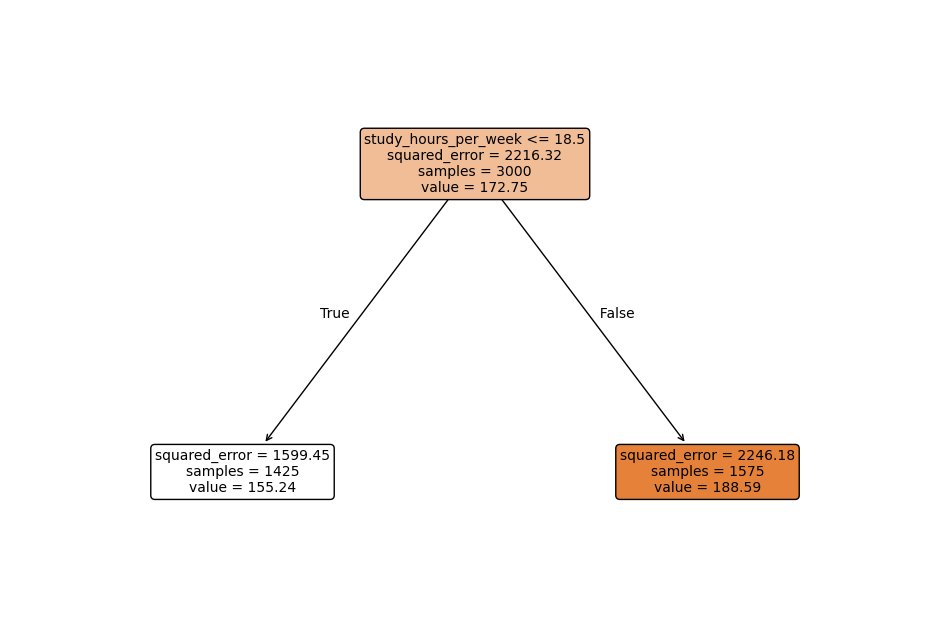

In [6]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

def plot_decision_tree(model, feature_names, max_depth=None, figsize=(12, 8)):
    """
    Plots a visually appealing representation of the decision tree.
    
    Parameters:
    - model: Trained DecisionTreeRegressor or DecisionTreeClassifier model.
    - feature_names: List of feature names for labeling the nodes.
    - max_depth: Maximum depth to display in the plot (default is None).
    - figsize: Tuple specifying figure size (default is (12, 8)).
    """
    plt.figure(figsize=figsize)
    plot_tree(
        model, 
        feature_names=feature_names, 
        filled=True, 
        rounded=True, 
        max_depth=max_depth,
        fontsize=10,
        precision=2
    )
    plt.show()

# Visualize the decision tree with max_depth=1
plot_decision_tree(dt, dv.feature_names_, max_depth=1)

# Question 2: Training a Random Forest Regressor

1. Train a Random Forest Regressor with the following parameters:
   - `n_estimators=10`
   - `random_state=1`
   - `n_jobs=-1` (optional, to utilize all available CPU cores)
2. Calculate the RMSE (Root Mean Squared Error) on the validation set to evaluate the model's performance.

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


def eval_random_forest(**kwargs):
    """
    Trains a Random Forest Regressor on the training set and returns the RMSE on the validation set.

    Returns:
    - rmse: Root Mean Squared Error on the validation set.
    """
    rf = RandomForestRegressor(**kwargs, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_val_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    return rmse


eval_random_forest(n_estimators=10)

np.float64(42.13724207871227)

# Question 3: Experimenting with `n_estimators` in Random Forest

1. Train a series of Random Forest Regressor models with `n_estimators` ranging from 10 to 200 in steps of 10.
2. Evaluate the model's performance on the validation set for each `n_estimators` value.
3. Determine the point at which RMSE no longer improves significantly (considering 3 decimal places for RMSE).

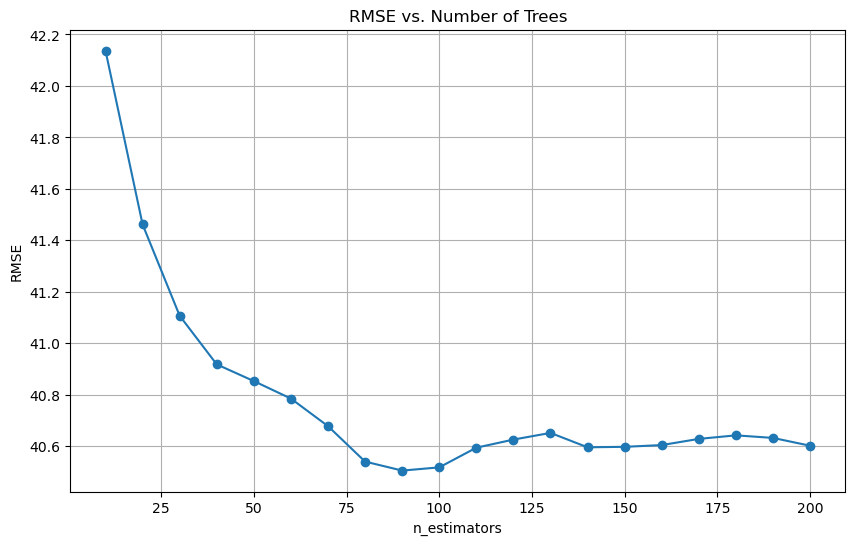

In [8]:
# Using the `eval_random_forest` function, we will train models with `n_estimators` ranging from 10 to 200 (in steps of 10) and plot the RMSE for each value.

rmse_values = [(n, eval_random_forest(n_estimators=n)) for n in range(10, 201, 10)]

# Extracting values for plotting
n_values, rmse_scores = zip(*rmse_values)

# Plotting RMSE vs. n_estimators
plt.figure(figsize=(10, 6))
plt.plot(n_values, rmse_scores, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('RMSE vs. Number of Trees')
plt.grid(True)
plt.show()

# Question 4: Selecting the Best `max_depth`

1. Experiment with different values of `max_depth` in `[10, 15, 20, 25]`.
2. For each `max_depth`, evaluate models with `n_estimators` ranging from 10 to 200 (in steps of 10).
3. Calculate the mean RMSE for each `max_depth` value and determine the best one.

In [9]:
depth_values = [10, 15, 20, 25]
results = {}

for max_depth in depth_values:
    rmse_list = [eval_random_forest(n_estimators=n, max_depth=max_depth) for n in range(10,201,10)]
    results[max_depth] = np.mean(rmse_list)

# Display results
results

{10: np.float64(40.39249798892396),
 15: np.float64(40.73528172486332),
 20: np.float64(40.739734321829275),
 25: np.float64(40.78786565962805)}

# Question 5: Extracting Feature Importance

In this section, we will:
1. Train a Random Forest Regressor with the following parameters:
   - `n_estimators=10`
   - `max_depth=20`
   - `random_state=1`
   - `n_jobs=-1` (optional for faster training)
2. Extract the feature importance information from the model to identify the most important feature.

In [10]:
# Train the Random Forest model
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

# Get feature importance information
importances = rf.feature_importances_

pd.DataFrame(data=dict(Features=dv.feature_names_, Importance=importances)).sort_values(
    'Importance', ascending=False)

,Features,Importance
27,study_hours_per_week,0.248354
4,attendance_rate,0.149729
5,distance_to_school,0.136486
28,teacher_quality,0.082682
2,age,0.069311
3,assignments_completed,0.031517
24,socioeconomic_status=High,0.025714
17,parent_involvement=High,0.022919
10,it_knowledge=High,0.017719
15,parent_education_level=Secondary,0.016957


# Question 6: Training an XGBoost Model with `eta` Tuning

1. Train two XGBoost models, one with `eta=0.3` and another with `eta=0.1`.
2. Compare the RMSE on the validation set for each model to identify the best `eta` value.

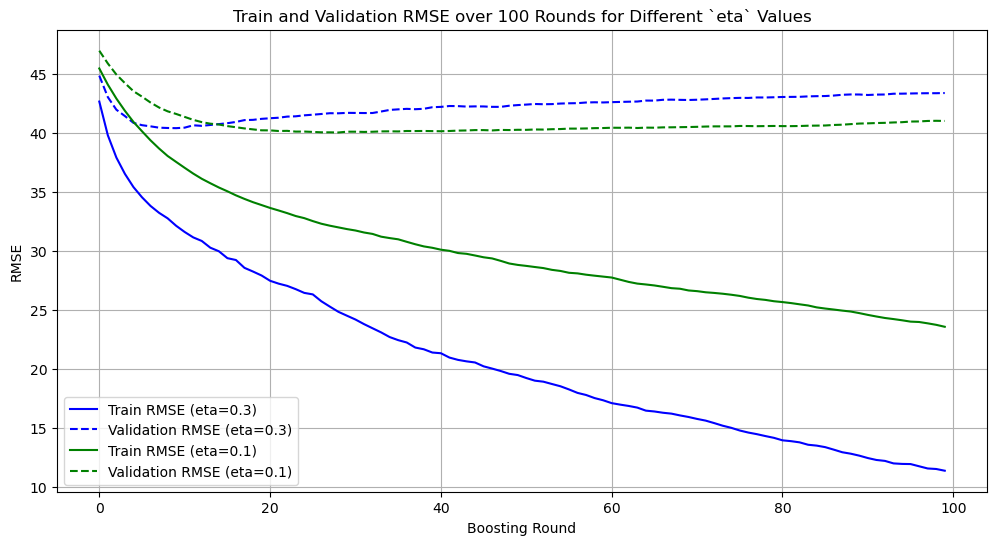

In [11]:
import xgboost as xgb

# Create DMatrix for train and validation (if not already created)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Define common XGBoost parameters
base_params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Create a watchlist for monitoring
watchlist = [(dtrain, 'train'), (dval, 'eval')]

def train_xgb_with_logging(eta_value):
    params = base_params.copy()
    params['eta'] = eta_value
    evals_result = {}  # Dictionary to store evaluation results
    model = xgb.train(params=params, 
                      dtrain=dtrain, 
                      num_boost_round=100, 
                      evals=watchlist, 
                      evals_result=evals_result, 
                      verbose_eval=False)
    return evals_result

# Train models and log RMSE for each round
results_eta_03 = train_xgb_with_logging(0.3)
results_eta_01 = train_xgb_with_logging(0.1)

# Plotting RMSE over iterations for both eta values
plt.figure(figsize=(12, 6))

# Plot train and eval RMSE for eta=0.3
plt.plot(results_eta_03['train']['rmse'], label='Train RMSE (eta=0.3)', color='blue')
plt.plot(results_eta_03['eval']['rmse'], label='Validation RMSE (eta=0.3)', color='blue', linestyle='--')

# Plot train and eval RMSE for eta=0.1
plt.plot(results_eta_01['train']['rmse'], label='Train RMSE (eta=0.1)', color='green')
plt.plot(results_eta_01['eval']['rmse'], label='Validation RMSE (eta=0.1)', color='green', linestyle='--')

# Adding labels and title
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('Train and Validation RMSE over 100 Rounds for Different `eta` Values')
plt.legend()
plt.grid(True)
plt.show()